In [1]:
import os
import cv2
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pytorch_lightning as pl
from torch import nn
from tqdm.notebook import tqdm

In [2]:
IMAGE_SIZE = 320
BATCH_SIZE = 16
EPOCHS = 5

color_dict = pd.read_csv('landCoverDataset/class_dict.csv')
CLASSES = color_dict['name']
print(color_dict)

               name    r    g    b
0        urban_land    0  255  255
1  agriculture_land  255  255    0
2         rangeland  255    0  255
3       forest_land    0  255    0
4             water    0    0  255
5       barren_land  255  255  255
6           unknown    0    0    0


In [3]:
from glob import glob
from sklearn.utils import shuffle

pd_dataset = pd.DataFrame({
    'IMAGES': sorted(glob("landCoverDataset/train/*.jpg")), 
    'MASKS': sorted(glob("landCoverDataset/train/*.png"))
})
pd_dataset = shuffle(pd_dataset)
pd_dataset.reset_index(inplace=True, drop=True)
pd_dataset.head()

,IMAGES,MASKS
0,landCoverDataset/train/939614_sat.jpg,landCoverDataset/train/939614_mask.png
1,landCoverDataset/train/351271_sat.jpg,landCoverDataset/train/351271_mask.png
2,landCoverDataset/train/428597_sat.jpg,landCoverDataset/train/428597_mask.png
3,landCoverDataset/train/140299_sat.jpg,landCoverDataset/train/140299_mask.png
4,landCoverDataset/train/513585_sat.jpg,landCoverDataset/train/513585_mask.png


In [4]:
from sklearn.model_selection import train_test_split

pd_train, pd_test = train_test_split(pd_dataset, test_size=0.25, random_state=0)
pd_train, pd_val = train_test_split(pd_train, test_size=0.2, random_state=0)

print("Training set size:", len(pd_train))
print("Validation set size:", len(pd_val))
print("Testing set size:", len(pd_test))

Training set size: 481
Validation set size: 121
Testing set size: 201


Premature end of JPEG file


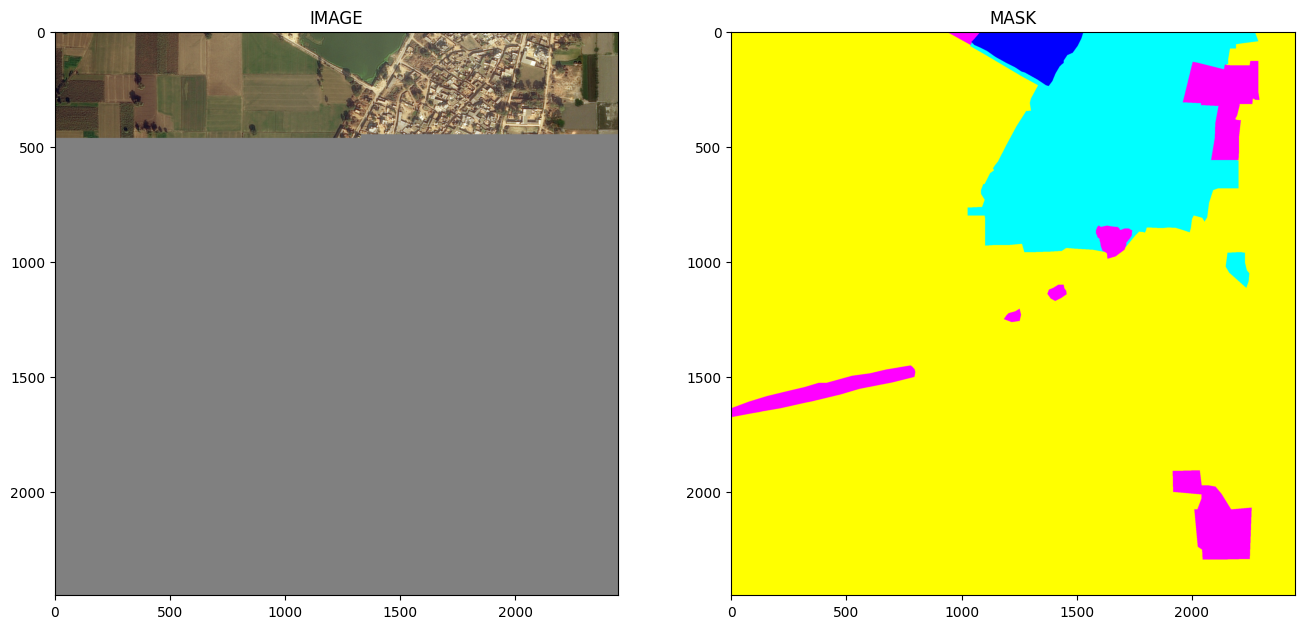

In [5]:
index = 200

sample_img = cv2.imread(pd_train.iloc[index].IMAGES)
sample_img = cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB)

sample_msk = cv2.imread(pd_train.iloc[index].MASKS)
sample_msk = cv2.cvtColor(sample_msk, cv2.COLOR_BGR2RGB)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 10))

ax1.set_title('IMAGE')
ax1.imshow(sample_img)

ax2.set_title('MASK')
ax2.imshow(sample_msk)

In [6]:
def rgb2category(rgb_mask):
    category_mask = np.zeros(rgb_mask.shape[:2], dtype=np.int8)
    for i, row in color_dict.iterrows():
        category_mask += (np.all(rgb_mask.reshape((-1, 3)) == (row['r'], row['g'], row['b']), axis=1).reshape(rgb_mask.shape[:2]) * i)
    return category_mask

def category2rgb(category_mask):
    rgb_mask = np.zeros(category_mask.shape[:2] + (3,))
    for i, row in color_dict.iterrows():
        rgb_mask[category_mask==i] = (row['r'], row['g'], row['b'])
    return np.uint8(rgb_mask)

In [7]:
import albumentations as aug

train_augment = aug.Compose([
    aug.Resize(IMAGE_SIZE, IMAGE_SIZE),
    aug.HorizontalFlip(p=0.5),
    aug.VerticalFlip(p=0.5),
    aug.RandomBrightnessContrast(p=0.3)
])

test_augment = aug.Compose([
    aug.Resize(IMAGE_SIZE, IMAGE_SIZE),
    aug.RandomBrightnessContrast(p=0.3)
])

In [8]:
from torch.utils.data import Dataset, DataLoader

class SegmentationDataset(Dataset):
    def __init__(self, df, augmentations=None):
        self.df = df
        self.augmentations = augmentations

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index: int):
        row = self.df.iloc[index]

        image = cv2.imread(row.IMAGES)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(row.MASKS)
        mask = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        if self.augmentations:
            data = self.augmentations(image=image, mask=mask)
            image = data['image']
            mask = data['mask']
        
        mask = rgb2category(mask)

        image = np.transpose(image, (2, 0, 1)).astype(np.float64)
        mask = np.expand_dims(mask, axis=0)

        image = torch.Tensor(image) / 255.0
        mask = torch.Tensor(mask).long()

        return image, mask


In [9]:
class SegmentationDataModule(pl.LightningDataModule):
    def __init__(self, pd_train, pd_val, pd_test, batch_size=10):
        super().__init__()
        self.pd_train = pd_train
        self.pd_val = pd_val
        self.pd_test = pd_test
        self.batch_size=batch_size

    def setup(self, stage=None):
        self.train_dataset = SegmentationDataset(self.pd_train, train_augment)
        self.val_dataset = SegmentationDataset(self.pd_val, test_augment)
        self.test_dataset = SegmentationDataset(self.pd_test, test_augment)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=2)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size // 2, shuffle=False, num_workers=1)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size // 2, shuffle=False, num_workers=1)

In [10]:
data_module = SegmentationDataModule(pd_train, pd_val, pd_test, batch_size=BATCH_SIZE)
data_module.setup()

In [11]:
image, mask = next(iter(data_module.train_dataloader()))
image.shape, mask.shape

/home/vpancho1/.conda/envs/rsenv/lib/python3.8/site-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of J

(torch.Size([16, 3, 320, 320]), torch.Size([16, 1, 320, 320]))

In [12]:
from segmentation_models_pytorch import UnetPlusPlus
from segmentation_models_pytorch.losses import DiceLoss
from segmentation_models_pytorch.metrics import get_stats, iou_score, accuracy, precision, recall, f1_score

class SegmentationModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = UnetPlusPlus(
            encoder_name="timm-regnety_120",
            encoder_weights="imagenet",
            in_channels=3,
            classes=len(CLASSES),
            activation="softmax"
        )
        self.criterion = DiceLoss(mode="multiclass", from_logits=False)
    
    def forward(self, inputs, targets=None):
        outputs = self.model(inputs)
        if targets is not None:
            loss = self.criterion(outputs, targets)
            tp, fp, fn, tn = get_stats(outputs.argmax(dim=1).unsqueeze(1).type(torch.int64), targets, mode='multiclass', num_classes=len(CLASSES))
            metrics = {
                "Accuracy": accuracy(tp, fp, fn, tn, reduction="micro-imagewise"),
                "IoU": iou_score(tp, fp, fn, tn, reduction="micro-imagewise"),
                "Precision": precision(tp, fp, fn, tn, reduction="micro-imagewise"),
                "Recall": recall(tp, fp, fn, tn, reduction="micro-imagewise"),
                "F1score": f1_score(tp, fp, fn, tn, reduction="micro-imagewise")
            }
            return loss, metrics, outputs
        else: 
            return outputs

    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=0.0001)

    def training_step(self, batch, batch_idx):
        images, masks = batch

        loss, metrics, outputs = self(images, masks)
        self.log_dict({
            "train/Loss": loss,
            "train/IoU": metrics['IoU'],
            "train/Accuracy": metrics['Accuracy'],
            "train/Precision": metrics['Precision'],
            "train/Recall": metrics['Recall'],
            "train/F1score": metrics['F1score']
        }, prog_bar=True, logger=True, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        images, masks = batch

        loss, metrics, outputs = self(images, masks)
        self.log_dict({
            "val/Loss": loss,
            "val/IoU": metrics['IoU'],
            "val/Accuracy": metrics['Accuracy'],
            "val/Precision": metrics['Precision'],
            "val/Recall": metrics['Recall'],
            "val/F1score": metrics['F1score']
        }, prog_bar=True, logger=True, on_step=False, on_epoch=True)
        return loss

    def test_step(self, batch, batch_idx):
        images, masks = batch

        loss, metrics, outputs = self(images, masks)
        self.log_dict({
            "test/Loss": loss,
            "test/IoU": metrics['IoU'],
            "test/Accuracy": metrics['Accuracy'],
            "test/Precision": metrics['Precision'],
            "test/Recall": metrics['Recall'],
            "test/F1score": metrics['F1score']
        }, prog_bar=True, logger=True, on_step=False, on_epoch=True)
        return loss

/home/vpancho1/.conda/envs/rsenv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [17]:
import torchinfo
from torchinfo import summary

model = SegmentationModel()
summary(model, input_size=(BATCH_SIZE, 3, IMAGE_SIZE, IMAGE_SIZE))

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-regnet/regnety_120-721ba79a.pth" to /home/vpancho1/.cache/torch/hub/checkpoints/regnety_120-721ba79a.pth
100%|██████████| 198M/198M [00:02<00:00, 77.3MB/s] 
/home/vpancho1/.conda/envs/rsenv/lib/python3.8/site-packages/segmentation_models_pytorch/base/modules.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)


Layer (type:depth-idx)                                  Output Shape              Param #
SegmentationModel                                       [16, 7, 320, 320]         --
├─UnetPlusPlus: 1-1                                     [16, 7, 320, 320]         --
│    └─RegNetEncoder: 2-1                               [16, 3, 320, 320]         --
│    │    └─ConvNormAct: 3-1                            [16, 32, 160, 160]        928
│    │    └─RegStage: 3-2                               [16, 224, 80, 80]         648,768
│    │    └─RegStage: 3-3                               [16, 448, 40, 40]         4,733,624
│    │    └─RegStage: 3-4                               [16, 896, 20, 20]         31,884,720
│    │    └─RegStage: 3-5                               [16, 2240, 10, 10]        12,313,504
│    └─UnetPlusPlusDecoder: 2-2                         [16, 16, 320, 320]        --
│    │    └─ModuleDict: 3-6                             --                        21,430,848
│    └─SegmentationHead

In [18]:
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import CSVLogger

checkpoint_callback = ModelCheckpoint(
    dirpath="checkpoints",
    filename="best-checkpoint",
    save_top_k=1,
    verbose=True,
    monitor="val/F1score",
    mode="min"
)

logger = CSVLogger("lightning_logs", name="landcover-classification-log")

early_stopping_callback = EarlyStopping(monitor="val/Accuracy", patience=5)

trainer = pl.Trainer(
    logger=logger,
    log_every_n_steps=31,
    callbacks=[checkpoint_callback, early_stopping_callback],
    max_epochs=EPOCHS,
    accelerator="gpu",
    devices=1
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [19]:
trainer.fit(model, data_module)

You are using a CUDA device ('NVIDIA A100-SXM4-80GB MIG 2g.20gb') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Missing logger folder: lightning_logs/landcover-classification-log
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type         | Params
-------------------------------------------
0 | model     | UnetPlusPlus | 71.0 M
1 | criterion | DiceLoss     | 0     
-------------------------------------------
71.0 M    Trainable params
0         Non-trainable params
71.0 M    Total params
284.054   Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

Premature end of JPEG file
/home/vpancho1/.conda/envs/rsenv/lib/python3.8/site-packages/segmentation_models_pytorch/base/modules.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)
Premature end of JPEG file


Sanity Checking DataLoader 0:  50%|█████     | 1/2 [00:00<00:00,  2.60it/s]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Premature end of JPEG file
/home/vpancho1/.conda/envs/rsenv/lib/python3.8/site-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 0:   0%|          | 0/31 [00:00<?, ?it/s] 

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
P

Epoch 0:   3%|▎         | 1/31 [00:11<05:40,  0.09it/s, v_num=0]

Premature end of JPEG file
Premature end of JPEG file


Epoch 0:   6%|▋         | 2/31 [00:11<02:49,  0.17it/s, v_num=0]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 0:  10%|▉         | 3/31 [00:12<01:56,  0.24it/s, v_num=0]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 0:  13%|█▎        | 4/31 [00:13<01:29,  0.30it/s, v_num=0]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 0:  16%|█▌        | 5/31 [00:16<01:25,  0.31it/s, v_num=0]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 0:  19%|█▉        | 6/31 [00:17<01:12,  0.34it/s, v_num=0]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 0:  23%|██▎       | 7/31 [00:21<01:12,  0.33it/s, v_num=0]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 0:  26%|██▌       | 8/31 [00:22<01:03,  0.36it/s, v_num=0]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 0:  29%|██▉       | 9/31 [00:25<01:02,  0.35it/s, v_num=0]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 0:  32%|███▏      | 10/31 [00:27<00:57,  0.37it/s, v_num=0]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 0:  35%|███▌      | 11/31 [00:30<00:55,  0.36it/s, v_num=0]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 0:  39%|███▊      | 12/31 [00:32<00:51,  0.37it/s, v_num=0]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 0:  42%|████▏     | 13/31 [00:34<00:48,  0.37it/s, v_num=0]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 0:  45%|████▌     | 14/31 [00:37<00:45,  0.38it/s, v_num=0]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 0:  48%|████▊     | 15/31 [00:39<00:41,  0.38it/s, v_num=0]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 0:  52%|█████▏    | 16/31 [00:42<00:39,  0.38it/s, v_num=0]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 0:  55%|█████▍    | 17/31 [00:44<00:36,  0.39it/s, v_num=0]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 0:  58%|█████▊    | 18/31 [00:46<00:33,  0.38it/s, v_num=0]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 0:  61%|██████▏   | 19/31 [00:48<00:30,  0.39it/s, v_num=0]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 0:  65%|██████▍   | 20/31 [00:51<00:28,  0.39it/s, v_num=0]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 0:  68%|██████▊   | 21/31 [00:53<00:25,  0.39it/s, v_num=0]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 0:  71%|███████   | 22/31 [00:56<00:23,  0.39it/s, v_num=0]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 0:  74%|███████▍  | 23/31 [00:58<00:20,  0.40it/s, v_num=0]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 0:  77%|███████▋  | 24/31 [01:01<00:17,  0.39it/s, v_num=0]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 0:  81%|████████  | 25/31 [01:03<00:15,  0.40it/s, v_num=0]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 0:  84%|████████▍ | 26/31 [01:06<00:12,  0.39it/s, v_num=0]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 0:  87%|████████▋ | 27/31 [01:07<00:10,  0.40it/s, v_num=0]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 0:  90%|█████████ | 28/31 [01:11<00:07,  0.39it/s, v_num=0]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 0:  94%|█████████▎| 29/31 [01:12<00:04,  0.40it/s, v_num=0]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 0: 100%|██████████| 31/31 [01:15<00:00,  0.41it/s, v_num=0]
Validation: |          | 0/? [00:00<?, ?it/s]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file



Validation DataLoader 0:   6%|▋         | 1/16 [00:00<00:02,  6.75it/s]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file



Validation DataLoader 0:  12%|█▎        | 2/16 [00:01<00:09,  1.54it/s]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file



Validation DataLoader 0:  19%|█▉        | 3/16 [00:02<00:10,  1.20it/s]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file



Validation DataLoader 0:  25%|██▌       | 4/16 [00:03<00:10,  1.09it/s]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file



Validation DataLoader 0:  31%|███▏      | 5/16 [00:04<00:10,  1.01it/s]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file



Validation DataLoader 0:  38%|███▊      | 6/16 [00:06<00:10,  0.97it/s]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file



Validation DataLoader 0:  44%|████▍     | 7/16 [00:07<00:09,  0.93it/s]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file



Validation DataLoader 0:  50%|█████     | 8/16 [00:08<00:08,  0.92it/s]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file



Validation DataLoader 0:  56%|█████▋    | 9/16 [00:09<00:07,  0.90it/s]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file



Validation DataLoader 0:  62%|██████▎   | 10/16 [00:11<00:06,  0.89it/s]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file



Validation DataLoader 0:  69%|██████▉   | 11/16 [00:12<00:05,  0.89it/s]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file



Validation DataLoader 0:  75%|███████▌  | 12/16 [00:13<00:04,  0.88it/s]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file



Validation DataLoader 0:  81%|████████▏ | 13/16 [00:14<00:03,  0.88it/s]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file



Validation DataLoader 0:  88%|████████▊ | 14/16 [00:16<00:02,  0.87it/s]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file



Epoch 0: 100%|██████████| 31/31 [01:34<00:00,  0.33it/s, v_num=0, val/Loss=0.184, val/IoU=0.561, val/Accuracy=0.919, val/Precision=0.718, val/Recall=0.718, val/F1score=0.718, train/Loss=0.203, train/IoU=0.371, train/Accuracy=0.857, train/Precision=0.498, train/Recall=0.498, train/F1score=0.498]

Premature end of JPEG file
Epoch 0, global step 31: 'val/F1score' reached 0.71771 (best 0.71771), saving model to '/home/vpancho1/OBIA/checkpoints/best-checkpoint.ckpt' as top 1


Epoch 1:   0%|          | 0/31 [00:00<?, ?it/s, v_num=0, val/Loss=0.184, val/IoU=0.561, val/Accuracy=0.919, val/Precision=0.718, val/Recall=0.718, val/F1score=0.718, train/Loss=0.203, train/IoU=0.371, train/Accuracy=0.857, train/Precision=0.498, train/Recall=0.498, train/F1score=0.498]         

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 1:   3%|▎         | 1/31 [00:06<03:08,  0.16it/s, v_num=0, val/Loss=0.184, val/IoU=0.561, val/Accuracy=0.919, val/Precision=0.718, val/Recall=0.718, val/F1score=0.718, train/Loss=0.203, train/IoU=0.371, train/Accuracy=0.857, train/Precision=0.498, train/Recall=0.498, train/F1score=0.498]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 1:   6%|▋         | 2/31 [00:07<01:42,  0.28it/s, v_num=0, val/Loss=0.184, val/IoU=0.561, val/Accuracy=0.919, val/Precision=0.718, val/Recall=0.718, val/F1score=0.718, train/Loss=0.203, train/IoU=0.371, train/Accuracy=0.857, train/Precision=0.498, train/Recall=0.498, train/F1score=0.498]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 1:  10%|▉         | 3/31 [00:10<01:42,  0.27it/s, v_num=0, val/Loss=0.184, val/IoU=0.561, val/Accuracy=0.919, val/Precision=0.718, val/Recall=0.718, val/F1score=0.718, train/Loss=0.203, train/IoU=0.371, train/Accuracy=0.857, train/Precision=0.498, train/Recall=0.498, train/F1score=0.498]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 1:  13%|█▎        | 4/31 [00:11<01:19,  0.34it/s, v_num=0, val/Loss=0.184, val/IoU=0.561, val/Accuracy=0.919, val/Precision=0.718, val/Recall=0.718, val/F1score=0.718, train/Loss=0.203, train/IoU=0.371, train/Accuracy=0.857, train/Precision=0.498, train/Recall=0.498, train/F1score=0.498]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 1:  16%|█▌        | 5/31 [00:15<01:21,  0.32it/s, v_num=0, val/Loss=0.184, val/IoU=0.561, val/Accuracy=0.919, val/Precision=0.718, val/Recall=0.718, val/F1score=0.718, train/Loss=0.203, train/IoU=0.371, train/Accuracy=0.857, train/Precision=0.498, train/Recall=0.498, train/F1score=0.498]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 1:  19%|█▉        | 6/31 [00:16<01:08,  0.36it/s, v_num=0, val/Loss=0.184, val/IoU=0.561, val/Accuracy=0.919, val/Precision=0.718, val/Recall=0.718, val/F1score=0.718, train/Loss=0.203, train/IoU=0.371, train/Accuracy=0.857, train/Precision=0.498, train/Recall=0.498, train/F1score=0.498]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 1:  23%|██▎       | 7/31 [00:20<01:10,  0.34it/s, v_num=0, val/Loss=0.184, val/IoU=0.561, val/Accuracy=0.919, val/Precision=0.718, val/Recall=0.718, val/F1score=0.718, train/Loss=0.203, train/IoU=0.371, train/Accuracy=0.857, train/Precision=0.498, train/Recall=0.498, train/F1score=0.498]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 1:  26%|██▌       | 8/31 [00:21<01:00,  0.38it/s, v_num=0, val/Loss=0.184, val/IoU=0.561, val/Accuracy=0.919, val/Precision=0.718, val/Recall=0.718, val/F1score=0.718, train/Loss=0.203, train/IoU=0.371, train/Accuracy=0.857, train/Precision=0.498, train/Recall=0.498, train/F1score=0.498]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 1:  29%|██▉       | 9/31 [00:25<01:01,  0.36it/s, v_num=0, val/Loss=0.184, val/IoU=0.561, val/Accuracy=0.919, val/Precision=0.718, val/Recall=0.718, val/F1score=0.718, train/Loss=0.203, train/IoU=0.371, train/Accuracy=0.857, train/Precision=0.498, train/Recall=0.498, train/F1score=0.498]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 1:  32%|███▏      | 10/31 [00:25<00:54,  0.39it/s, v_num=0, val/Loss=0.184, val/IoU=0.561, val/Accuracy=0.919, val/Precision=0.718, val/Recall=0.718, val/F1score=0.718, train/Loss=0.203, train/IoU=0.371, train/Accuracy=0.857, train/Precision=0.498, train/Recall=0.498, train/F1score=0.498]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 1:  35%|███▌      | 11/31 [00:29<00:54,  0.37it/s, v_num=0, val/Loss=0.184, val/IoU=0.561, val/Accuracy=0.919, val/Precision=0.718, val/Recall=0.718, val/F1score=0.718, train/Loss=0.203, train/IoU=0.371, train/Accuracy=0.857, train/Precision=0.498, train/Recall=0.498, train/F1score=0.498]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 1:  39%|███▊      | 12/31 [00:30<00:48,  0.39it/s, v_num=0, val/Loss=0.184, val/IoU=0.561, val/Accuracy=0.919, val/Precision=0.718, val/Recall=0.718, val/F1score=0.718, train/Loss=0.203, train/IoU=0.371, train/Accuracy=0.857, train/Precision=0.498, train/Recall=0.498, train/F1score=0.498]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 1:  42%|████▏     | 13/31 [00:34<00:47,  0.38it/s, v_num=0, val/Loss=0.184, val/IoU=0.561, val/Accuracy=0.919, val/Precision=0.718, val/Recall=0.718, val/F1score=0.718, train/Loss=0.203, train/IoU=0.371, train/Accuracy=0.857, train/Precision=0.498, train/Recall=0.498, train/F1score=0.498]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 1:  45%|████▌     | 14/31 [00:35<00:42,  0.40it/s, v_num=0, val/Loss=0.184, val/IoU=0.561, val/Accuracy=0.919, val/Precision=0.718, val/Recall=0.718, val/F1score=0.718, train/Loss=0.203, train/IoU=0.371, train/Accuracy=0.857, train/Precision=0.498, train/Recall=0.498, train/F1score=0.498]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 1:  48%|████▊     | 15/31 [00:38<00:41,  0.39it/s, v_num=0, val/Loss=0.184, val/IoU=0.561, val/Accuracy=0.919, val/Precision=0.718, val/Recall=0.718, val/F1score=0.718, train/Loss=0.203, train/IoU=0.371, train/Accuracy=0.857, train/Precision=0.498, train/Recall=0.498, train/F1score=0.498]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 1:  52%|█████▏    | 16/31 [00:39<00:37,  0.40it/s, v_num=0, val/Loss=0.184, val/IoU=0.561, val/Accuracy=0.919, val/Precision=0.718, val/Recall=0.718, val/F1score=0.718, train/Loss=0.203, train/IoU=0.371, train/Accuracy=0.857, train/Precision=0.498, train/Recall=0.498, train/F1score=0.498]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 1:  55%|█████▍    | 17/31 [00:43<00:35,  0.39it/s, v_num=0, val/Loss=0.184, val/IoU=0.561, val/Accuracy=0.919, val/Precision=0.718, val/Recall=0.718, val/F1score=0.718, train/Loss=0.203, train/IoU=0.371, train/Accuracy=0.857, train/Precision=0.498, train/Recall=0.498, train/F1score=0.498]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 1:  58%|█████▊    | 18/31 [00:44<00:32,  0.40it/s, v_num=0, val/Loss=0.184, val/IoU=0.561, val/Accuracy=0.919, val/Precision=0.718, val/Recall=0.718, val/F1score=0.718, train/Loss=0.203, train/IoU=0.371, train/Accuracy=0.857, train/Precision=0.498, train/Recall=0.498, train/F1score=0.498]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 1:  61%|██████▏   | 19/31 [00:47<00:30,  0.40it/s, v_num=0, val/Loss=0.184, val/IoU=0.561, val/Accuracy=0.919, val/Precision=0.718, val/Recall=0.718, val/F1score=0.718, train/Loss=0.203, train/IoU=0.371, train/Accuracy=0.857, train/Precision=0.498, train/Recall=0.498, train/F1score=0.498]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 1:  65%|██████▍   | 20/31 [00:49<00:27,  0.41it/s, v_num=0, val/Loss=0.184, val/IoU=0.561, val/Accuracy=0.919, val/Precision=0.718, val/Recall=0.718, val/F1score=0.718, train/Loss=0.203, train/IoU=0.371, train/Accuracy=0.857, train/Precision=0.498, train/Recall=0.498, train/F1score=0.498]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 1:  68%|██████▊   | 21/31 [00:52<00:24,  0.40it/s, v_num=0, val/Loss=0.184, val/IoU=0.561, val/Accuracy=0.919, val/Precision=0.718, val/Recall=0.718, val/F1score=0.718, train/Loss=0.203, train/IoU=0.371, train/Accuracy=0.857, train/Precision=0.498, train/Recall=0.498, train/F1score=0.498]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 1:  71%|███████   | 22/31 [00:53<00:22,  0.41it/s, v_num=0, val/Loss=0.184, val/IoU=0.561, val/Accuracy=0.919, val/Precision=0.718, val/Recall=0.718, val/F1score=0.718, train/Loss=0.203, train/IoU=0.371, train/Accuracy=0.857, train/Precision=0.498, train/Recall=0.498, train/F1score=0.498]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 1:  74%|███████▍  | 23/31 [00:57<00:19,  0.40it/s, v_num=0, val/Loss=0.184, val/IoU=0.561, val/Accuracy=0.919, val/Precision=0.718, val/Recall=0.718, val/F1score=0.718, train/Loss=0.203, train/IoU=0.371, train/Accuracy=0.857, train/Precision=0.498, train/Recall=0.498, train/F1score=0.498]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 1:  77%|███████▋  | 24/31 [00:58<00:17,  0.41it/s, v_num=0, val/Loss=0.184, val/IoU=0.561, val/Accuracy=0.919, val/Precision=0.718, val/Recall=0.718, val/F1score=0.718, train/Loss=0.203, train/IoU=0.371, train/Accuracy=0.857, train/Precision=0.498, train/Recall=0.498, train/F1score=0.498]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 1:  81%|████████  | 25/31 [01:01<00:14,  0.41it/s, v_num=0, val/Loss=0.184, val/IoU=0.561, val/Accuracy=0.919, val/Precision=0.718, val/Recall=0.718, val/F1score=0.718, train/Loss=0.203, train/IoU=0.371, train/Accuracy=0.857, train/Precision=0.498, train/Recall=0.498, train/F1score=0.498]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 1:  84%|████████▍ | 26/31 [01:03<00:12,  0.41it/s, v_num=0, val/Loss=0.184, val/IoU=0.561, val/Accuracy=0.919, val/Precision=0.718, val/Recall=0.718, val/F1score=0.718, train/Loss=0.203, train/IoU=0.371, train/Accuracy=0.857, train/Precision=0.498, train/Recall=0.498, train/F1score=0.498]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 1:  87%|████████▋ | 27/31 [01:06<00:09,  0.41it/s, v_num=0, val/Loss=0.184, val/IoU=0.561, val/Accuracy=0.919, val/Precision=0.718, val/Recall=0.718, val/F1score=0.718, train/Loss=0.203, train/IoU=0.371, train/Accuracy=0.857, train/Precision=0.498, train/Recall=0.498, train/F1score=0.498]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 1:  90%|█████████ | 28/31 [01:07<00:07,  0.41it/s, v_num=0, val/Loss=0.184, val/IoU=0.561, val/Accuracy=0.919, val/Precision=0.718, val/Recall=0.718, val/F1score=0.718, train/Loss=0.203, train/IoU=0.371, train/Accuracy=0.857, train/Precision=0.498, train/Recall=0.498, train/F1score=0.498]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 1:  94%|█████████▎| 29/31 [01:10<00:04,  0.41it/s, v_num=0, val/Loss=0.184, val/IoU=0.561, val/Accuracy=0.919, val/Precision=0.718, val/Recall=0.718, val/F1score=0.718, train/Loss=0.203, train/IoU=0.371, train/Accuracy=0.857, train/Precision=0.498, train/Recall=0.498, train/F1score=0.498]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 1: 100%|██████████| 31/31 [01:12<00:00,  0.43it/s, v_num=0, val/Loss=0.184, val/IoU=0.561, val/Accuracy=0.919, val/Precision=0.718, val/Recall=0.718, val/F1score=0.718, train/Loss=0.203, train/IoU=0.371, train/Accuracy=0.857, train/Precision=0.498, train/Recall=0.498, train/F1score=0.498]
Validation: |          | 0/? [00:00<?, ?it/s]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file



Validation DataLoader 0:   6%|▋         | 1/16 [00:00<00:02,  6.40it/s]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file



Validation DataLoader 0:  12%|█▎        | 2/16 [00:01<00:09,  1.52it/s]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file



Validation DataLoader 0:  19%|█▉        | 3/16 [00:02<00:11,  1.17it/s]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file



Validation DataLoader 0:  25%|██▌       | 4/16 [00:03<00:11,  1.07it/s]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file



Validation DataLoader 0:  31%|███▏      | 5/16 [00:04<00:10,  1.01it/s]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file



Validation DataLoader 0:  38%|███▊      | 6/16 [00:06<00:10,  0.97it/s]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file



Validation DataLoader 0:  44%|████▍     | 7/16 [00:07<00:09,  0.95it/s]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file



Validation DataLoader 0:  50%|█████     | 8/16 [00:08<00:08,  0.93it/s]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file



Validation DataLoader 0:  56%|█████▋    | 9/16 [00:09<00:07,  0.92it/s]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file



Validation DataLoader 0:  62%|██████▎   | 10/16 [00:11<00:06,  0.91it/s]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file



Validation DataLoader 0:  69%|██████▉   | 11/16 [00:12<00:05,  0.90it/s]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file



Validation DataLoader 0:  75%|███████▌  | 12/16 [00:13<00:04,  0.89it/s]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file



Validation DataLoader 0:  81%|████████▏ | 13/16 [00:14<00:03,  0.89it/s]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file



Validation DataLoader 0:  88%|████████▊ | 14/16 [00:15<00:02,  0.88it/s]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file



Epoch 1: 100%|██████████| 31/31 [01:31<00:00,  0.34it/s, v_num=0, val/Loss=0.169, val/IoU=0.555, val/Accuracy=0.918, val/Precision=0.713, val/Recall=0.713, val/F1score=0.713, train/Loss=0.218, train/IoU=0.539, train/Accuracy=0.914, train/Precision=0.700, train/Recall=0.700, train/F1score=0.700]

Epoch 1, global step 62: 'val/F1score' reached 0.71289 (best 0.71289), saving model to '/home/vpancho1/OBIA/checkpoints/best-checkpoint.ckpt' as top 1


Epoch 2:   0%|          | 0/31 [00:00<?, ?it/s, v_num=0, val/Loss=0.169, val/IoU=0.555, val/Accuracy=0.918, val/Precision=0.713, val/Recall=0.713, val/F1score=0.713, train/Loss=0.218, train/IoU=0.539, train/Accuracy=0.914, train/Precision=0.700, train/Recall=0.700, train/F1score=0.700]         

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 2:   3%|▎         | 1/31 [00:06<03:07,  0.16it/s, v_num=0, val/Loss=0.169, val/IoU=0.555, val/Accuracy=0.918, val/Precision=0.713, val/Recall=0.713, val/F1score=0.713, train/Loss=0.218, train/IoU=0.539, train/Accuracy=0.914, train/Precision=0.700, train/Recall=0.700, train/F1score=0.700]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 2:   6%|▋         | 2/31 [00:07<01:42,  0.28it/s, v_num=0, val/Loss=0.169, val/IoU=0.555, val/Accuracy=0.918, val/Precision=0.713, val/Recall=0.713, val/F1score=0.713, train/Loss=0.218, train/IoU=0.539, train/Accuracy=0.914, train/Precision=0.700, train/Recall=0.700, train/F1score=0.700]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 2:  10%|▉         | 3/31 [00:11<01:42,  0.27it/s, v_num=0, val/Loss=0.169, val/IoU=0.555, val/Accuracy=0.918, val/Precision=0.713, val/Recall=0.713, val/F1score=0.713, train/Loss=0.218, train/IoU=0.539, train/Accuracy=0.914, train/Precision=0.700, train/Recall=0.700, train/F1score=0.700]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 2:  13%|█▎        | 4/31 [00:11<01:19,  0.34it/s, v_num=0, val/Loss=0.169, val/IoU=0.555, val/Accuracy=0.918, val/Precision=0.713, val/Recall=0.713, val/F1score=0.713, train/Loss=0.218, train/IoU=0.539, train/Accuracy=0.914, train/Precision=0.700, train/Recall=0.700, train/F1score=0.700]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 2:  16%|█▌        | 5/31 [00:15<01:22,  0.32it/s, v_num=0, val/Loss=0.169, val/IoU=0.555, val/Accuracy=0.918, val/Precision=0.713, val/Recall=0.713, val/F1score=0.713, train/Loss=0.218, train/IoU=0.539, train/Accuracy=0.914, train/Precision=0.700, train/Recall=0.700, train/F1score=0.700]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 2:  19%|█▉        | 6/31 [00:16<01:08,  0.36it/s, v_num=0, val/Loss=0.169, val/IoU=0.555, val/Accuracy=0.918, val/Precision=0.713, val/Recall=0.713, val/F1score=0.713, train/Loss=0.218, train/IoU=0.539, train/Accuracy=0.914, train/Precision=0.700, train/Recall=0.700, train/F1score=0.700]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 2:  23%|██▎       | 7/31 [00:20<01:10,  0.34it/s, v_num=0, val/Loss=0.169, val/IoU=0.555, val/Accuracy=0.918, val/Precision=0.713, val/Recall=0.713, val/F1score=0.713, train/Loss=0.218, train/IoU=0.539, train/Accuracy=0.914, train/Precision=0.700, train/Recall=0.700, train/F1score=0.700]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 2:  26%|██▌       | 8/31 [00:21<01:01,  0.37it/s, v_num=0, val/Loss=0.169, val/IoU=0.555, val/Accuracy=0.918, val/Precision=0.713, val/Recall=0.713, val/F1score=0.713, train/Loss=0.218, train/IoU=0.539, train/Accuracy=0.914, train/Precision=0.700, train/Recall=0.700, train/F1score=0.700]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 2:  29%|██▉       | 9/31 [00:25<01:02,  0.35it/s, v_num=0, val/Loss=0.169, val/IoU=0.555, val/Accuracy=0.918, val/Precision=0.713, val/Recall=0.713, val/F1score=0.713, train/Loss=0.218, train/IoU=0.539, train/Accuracy=0.914, train/Precision=0.700, train/Recall=0.700, train/F1score=0.700]

Premature end of JPEG file


Epoch 2:  29%|██▉       | 9/31 [00:25<01:02,  0.35it/s, v_num=0, val/Loss=0.169, val/IoU=0.555, val/Accuracy=0.918, val/Precision=0.713, val/Recall=0.713, val/F1score=0.713, train/Loss=0.218, train/IoU=0.539, train/Accuracy=0.914, train/Precision=0.700, train/Recall=0.700, train/F1score=0.700]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 2:  32%|███▏      | 10/31 [00:26<00:54,  0.38it/s, v_num=0, val/Loss=0.169, val/IoU=0.555, val/Accuracy=0.918, val/Precision=0.713, val/Recall=0.713, val/F1score=0.713, train/Loss=0.218, train/IoU=0.539, train/Accuracy=0.914, train/Precision=0.700, train/Recall=0.700, train/F1score=0.700]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 2:  35%|███▌      | 11/31 [00:30<00:54,  0.36it/s, v_num=0, val/Loss=0.169, val/IoU=0.555, val/Accuracy=0.918, val/Precision=0.713, val/Recall=0.713, val/F1score=0.713, train/Loss=0.218, train/IoU=0.539, train/Accuracy=0.914, train/Precision=0.700, train/Recall=0.700, train/F1score=0.700]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 2:  39%|███▊      | 12/31 [00:30<00:48,  0.39it/s, v_num=0, val/Loss=0.169, val/IoU=0.555, val/Accuracy=0.918, val/Precision=0.713, val/Recall=0.713, val/F1score=0.713, train/Loss=0.218, train/IoU=0.539, train/Accuracy=0.914, train/Precision=0.700, train/Recall=0.700, train/F1score=0.700]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 2:  42%|████▏     | 13/31 [00:34<00:48,  0.37it/s, v_num=0, val/Loss=0.169, val/IoU=0.555, val/Accuracy=0.918, val/Precision=0.713, val/Recall=0.713, val/F1score=0.713, train/Loss=0.218, train/IoU=0.539, train/Accuracy=0.914, train/Precision=0.700, train/Recall=0.700, train/F1score=0.700]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 2:  45%|████▌     | 14/31 [00:35<00:43,  0.39it/s, v_num=0, val/Loss=0.169, val/IoU=0.555, val/Accuracy=0.918, val/Precision=0.713, val/Recall=0.713, val/F1score=0.713, train/Loss=0.218, train/IoU=0.539, train/Accuracy=0.914, train/Precision=0.700, train/Recall=0.700, train/F1score=0.700]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 2:  48%|████▊     | 15/31 [00:39<00:42,  0.38it/s, v_num=0, val/Loss=0.169, val/IoU=0.555, val/Accuracy=0.918, val/Precision=0.713, val/Recall=0.713, val/F1score=0.713, train/Loss=0.218, train/IoU=0.539, train/Accuracy=0.914, train/Precision=0.700, train/Recall=0.700, train/F1score=0.700]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 2:  52%|█████▏    | 16/31 [00:40<00:37,  0.40it/s, v_num=0, val/Loss=0.169, val/IoU=0.555, val/Accuracy=0.918, val/Precision=0.713, val/Recall=0.713, val/F1score=0.713, train/Loss=0.218, train/IoU=0.539, train/Accuracy=0.914, train/Precision=0.700, train/Recall=0.700, train/F1score=0.700]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 2:  55%|█████▍    | 17/31 [00:44<00:36,  0.38it/s, v_num=0, val/Loss=0.169, val/IoU=0.555, val/Accuracy=0.918, val/Precision=0.713, val/Recall=0.713, val/F1score=0.713, train/Loss=0.218, train/IoU=0.539, train/Accuracy=0.914, train/Precision=0.700, train/Recall=0.700, train/F1score=0.700]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 2:  58%|█████▊    | 18/31 [00:45<00:32,  0.40it/s, v_num=0, val/Loss=0.169, val/IoU=0.555, val/Accuracy=0.918, val/Precision=0.713, val/Recall=0.713, val/F1score=0.713, train/Loss=0.218, train/IoU=0.539, train/Accuracy=0.914, train/Precision=0.700, train/Recall=0.700, train/F1score=0.700]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 2:  61%|██████▏   | 19/31 [00:49<00:30,  0.39it/s, v_num=0, val/Loss=0.169, val/IoU=0.555, val/Accuracy=0.918, val/Precision=0.713, val/Recall=0.713, val/F1score=0.713, train/Loss=0.218, train/IoU=0.539, train/Accuracy=0.914, train/Precision=0.700, train/Recall=0.700, train/F1score=0.700]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 2:  65%|██████▍   | 20/31 [00:49<00:27,  0.40it/s, v_num=0, val/Loss=0.169, val/IoU=0.555, val/Accuracy=0.918, val/Precision=0.713, val/Recall=0.713, val/F1score=0.713, train/Loss=0.218, train/IoU=0.539, train/Accuracy=0.914, train/Precision=0.700, train/Recall=0.700, train/F1score=0.700]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 2:  68%|██████▊   | 21/31 [00:53<00:25,  0.39it/s, v_num=0, val/Loss=0.169, val/IoU=0.555, val/Accuracy=0.918, val/Precision=0.713, val/Recall=0.713, val/F1score=0.713, train/Loss=0.218, train/IoU=0.539, train/Accuracy=0.914, train/Precision=0.700, train/Recall=0.700, train/F1score=0.700]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 2:  71%|███████   | 22/31 [00:54<00:22,  0.40it/s, v_num=0, val/Loss=0.169, val/IoU=0.555, val/Accuracy=0.918, val/Precision=0.713, val/Recall=0.713, val/F1score=0.713, train/Loss=0.218, train/IoU=0.539, train/Accuracy=0.914, train/Precision=0.700, train/Recall=0.700, train/F1score=0.700]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 2:  74%|███████▍  | 23/31 [00:58<00:20,  0.39it/s, v_num=0, val/Loss=0.169, val/IoU=0.555, val/Accuracy=0.918, val/Precision=0.713, val/Recall=0.713, val/F1score=0.713, train/Loss=0.218, train/IoU=0.539, train/Accuracy=0.914, train/Precision=0.700, train/Recall=0.700, train/F1score=0.700]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 2:  77%|███████▋  | 24/31 [00:59<00:17,  0.40it/s, v_num=0, val/Loss=0.169, val/IoU=0.555, val/Accuracy=0.918, val/Precision=0.713, val/Recall=0.713, val/F1score=0.713, train/Loss=0.218, train/IoU=0.539, train/Accuracy=0.914, train/Precision=0.700, train/Recall=0.700, train/F1score=0.700]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 2:  81%|████████  | 25/31 [01:03<00:15,  0.39it/s, v_num=0, val/Loss=0.169, val/IoU=0.555, val/Accuracy=0.918, val/Precision=0.713, val/Recall=0.713, val/F1score=0.713, train/Loss=0.218, train/IoU=0.539, train/Accuracy=0.914, train/Precision=0.700, train/Recall=0.700, train/F1score=0.700]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 2:  84%|████████▍ | 26/31 [01:04<00:12,  0.41it/s, v_num=0, val/Loss=0.169, val/IoU=0.555, val/Accuracy=0.918, val/Precision=0.713, val/Recall=0.713, val/F1score=0.713, train/Loss=0.218, train/IoU=0.539, train/Accuracy=0.914, train/Precision=0.700, train/Recall=0.700, train/F1score=0.700]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 2:  87%|████████▋ | 27/31 [01:08<00:10,  0.40it/s, v_num=0, val/Loss=0.169, val/IoU=0.555, val/Accuracy=0.918, val/Precision=0.713, val/Recall=0.713, val/F1score=0.713, train/Loss=0.218, train/IoU=0.539, train/Accuracy=0.914, train/Precision=0.700, train/Recall=0.700, train/F1score=0.700]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 2:  90%|█████████ | 28/31 [01:08<00:07,  0.41it/s, v_num=0, val/Loss=0.169, val/IoU=0.555, val/Accuracy=0.918, val/Precision=0.713, val/Recall=0.713, val/F1score=0.713, train/Loss=0.218, train/IoU=0.539, train/Accuracy=0.914, train/Precision=0.700, train/Recall=0.700, train/F1score=0.700]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 2: 100%|██████████| 31/31 [01:13<00:00,  0.42it/s, v_num=0, val/Loss=0.169, val/IoU=0.555, val/Accuracy=0.918, val/Precision=0.713, val/Recall=0.713, val/F1score=0.713, train/Loss=0.218, train/IoU=0.539, train/Accuracy=0.914, train/Precision=0.700, train/Recall=0.700, train/F1score=0.700]
Validation: |          | 0/? [00:00<?, ?it/s]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file



Validation DataLoader 0:   6%|▋         | 1/16 [00:00<00:02,  6.48it/s]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file



Validation DataLoader 0:  12%|█▎        | 2/16 [00:01<00:09,  1.43it/s]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file



Validation DataLoader 0:  19%|█▉        | 3/16 [00:02<00:11,  1.13it/s]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file



Validation DataLoader 0:  25%|██▌       | 4/16 [00:03<00:11,  1.02it/s]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file



Validation DataLoader 0:  31%|███▏      | 5/16 [00:05<00:11,  0.97it/s]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file



Validation DataLoader 0:  38%|███▊      | 6/16 [00:06<00:10,  0.93it/s]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file



Validation DataLoader 0:  44%|████▍     | 7/16 [00:07<00:09,  0.91it/s]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file



Validation DataLoader 0:  50%|█████     | 8/16 [00:08<00:08,  0.90it/s]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file



Validation DataLoader 0:  56%|█████▋    | 9/16 [00:10<00:07,  0.88it/s]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file



Validation DataLoader 0:  62%|██████▎   | 10/16 [00:11<00:06,  0.87it/s]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file



Validation DataLoader 0:  69%|██████▉   | 11/16 [00:12<00:05,  0.87it/s]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file



Validation DataLoader 0:  75%|███████▌  | 12/16 [00:13<00:04,  0.86it/s]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file



Validation DataLoader 0:  81%|████████▏ | 13/16 [00:15<00:03,  0.85it/s]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file



Validation DataLoader 0:  88%|████████▊ | 14/16 [00:16<00:02,  0.85it/s]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file



Epoch 2: 100%|██████████| 31/31 [01:32<00:00,  0.33it/s, v_num=0, val/Loss=0.154, val/IoU=0.454, val/Accuracy=0.892, val/Precision=0.623, val/Recall=0.623, val/F1score=0.623, train/Loss=0.195, train/IoU=0.470, train/Accuracy=0.896, train/Precision=0.637, train/Recall=0.637, train/F1score=0.637]

Epoch 2, global step 93: 'val/F1score' reached 0.62337 (best 0.62337), saving model to '/home/vpancho1/OBIA/checkpoints/best-checkpoint.ckpt' as top 1


Epoch 3:   0%|          | 0/31 [00:00<?, ?it/s, v_num=0, val/Loss=0.154, val/IoU=0.454, val/Accuracy=0.892, val/Precision=0.623, val/Recall=0.623, val/F1score=0.623, train/Loss=0.195, train/IoU=0.470, train/Accuracy=0.896, train/Precision=0.637, train/Recall=0.637, train/F1score=0.637]         

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 3:   3%|▎         | 1/31 [00:06<03:10,  0.16it/s, v_num=0, val/Loss=0.154, val/IoU=0.454, val/Accuracy=0.892, val/Precision=0.623, val/Recall=0.623, val/F1score=0.623, train/Loss=0.195, train/IoU=0.470, train/Accuracy=0.896, train/Precision=0.637, train/Recall=0.637, train/F1score=0.637]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 3:   6%|▋         | 2/31 [00:07<01:43,  0.28it/s, v_num=0, val/Loss=0.154, val/IoU=0.454, val/Accuracy=0.892, val/Precision=0.623, val/Recall=0.623, val/F1score=0.623, train/Loss=0.195, train/IoU=0.470, train/Accuracy=0.896, train/Precision=0.637, train/Recall=0.637, train/F1score=0.637]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 3:  10%|▉         | 3/31 [00:11<01:43,  0.27it/s, v_num=0, val/Loss=0.154, val/IoU=0.454, val/Accuracy=0.892, val/Precision=0.623, val/Recall=0.623, val/F1score=0.623, train/Loss=0.195, train/IoU=0.470, train/Accuracy=0.896, train/Precision=0.637, train/Recall=0.637, train/F1score=0.637]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 3:  13%|█▎        | 4/31 [00:11<01:20,  0.34it/s, v_num=0, val/Loss=0.154, val/IoU=0.454, val/Accuracy=0.892, val/Precision=0.623, val/Recall=0.623, val/F1score=0.623, train/Loss=0.195, train/IoU=0.470, train/Accuracy=0.896, train/Precision=0.637, train/Recall=0.637, train/F1score=0.637]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 3:  16%|█▌        | 5/31 [00:15<01:22,  0.31it/s, v_num=0, val/Loss=0.154, val/IoU=0.454, val/Accuracy=0.892, val/Precision=0.623, val/Recall=0.623, val/F1score=0.623, train/Loss=0.195, train/IoU=0.470, train/Accuracy=0.896, train/Precision=0.637, train/Recall=0.637, train/F1score=0.637]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 3:  19%|█▉        | 6/31 [00:16<01:09,  0.36it/s, v_num=0, val/Loss=0.154, val/IoU=0.454, val/Accuracy=0.892, val/Precision=0.623, val/Recall=0.623, val/F1score=0.623, train/Loss=0.195, train/IoU=0.470, train/Accuracy=0.896, train/Precision=0.637, train/Recall=0.637, train/F1score=0.637]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 3:  23%|██▎       | 7/31 [00:20<01:11,  0.34it/s, v_num=0, val/Loss=0.154, val/IoU=0.454, val/Accuracy=0.892, val/Precision=0.623, val/Recall=0.623, val/F1score=0.623, train/Loss=0.195, train/IoU=0.470, train/Accuracy=0.896, train/Precision=0.637, train/Recall=0.637, train/F1score=0.637]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 3:  26%|██▌       | 8/31 [00:21<01:02,  0.37it/s, v_num=0, val/Loss=0.154, val/IoU=0.454, val/Accuracy=0.892, val/Precision=0.623, val/Recall=0.623, val/F1score=0.623, train/Loss=0.195, train/IoU=0.470, train/Accuracy=0.896, train/Precision=0.637, train/Recall=0.637, train/F1score=0.637]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 3:  29%|██▉       | 9/31 [00:25<01:02,  0.35it/s, v_num=0, val/Loss=0.154, val/IoU=0.454, val/Accuracy=0.892, val/Precision=0.623, val/Recall=0.623, val/F1score=0.623, train/Loss=0.195, train/IoU=0.470, train/Accuracy=0.896, train/Precision=0.637, train/Recall=0.637, train/F1score=0.637]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 3:  32%|███▏      | 10/31 [00:26<00:55,  0.38it/s, v_num=0, val/Loss=0.154, val/IoU=0.454, val/Accuracy=0.892, val/Precision=0.623, val/Recall=0.623, val/F1score=0.623, train/Loss=0.195, train/IoU=0.470, train/Accuracy=0.896, train/Precision=0.637, train/Recall=0.637, train/F1score=0.637]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 3:  35%|███▌      | 11/31 [00:30<00:55,  0.36it/s, v_num=0, val/Loss=0.154, val/IoU=0.454, val/Accuracy=0.892, val/Precision=0.623, val/Recall=0.623, val/F1score=0.623, train/Loss=0.195, train/IoU=0.470, train/Accuracy=0.896, train/Precision=0.637, train/Recall=0.637, train/F1score=0.637]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 3:  39%|███▊      | 12/31 [00:31<00:49,  0.38it/s, v_num=0, val/Loss=0.154, val/IoU=0.454, val/Accuracy=0.892, val/Precision=0.623, val/Recall=0.623, val/F1score=0.623, train/Loss=0.195, train/IoU=0.470, train/Accuracy=0.896, train/Precision=0.637, train/Recall=0.637, train/F1score=0.637]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 3:  42%|████▏     | 13/31 [00:35<00:48,  0.37it/s, v_num=0, val/Loss=0.154, val/IoU=0.454, val/Accuracy=0.892, val/Precision=0.623, val/Recall=0.623, val/F1score=0.623, train/Loss=0.195, train/IoU=0.470, train/Accuracy=0.896, train/Precision=0.637, train/Recall=0.637, train/F1score=0.637]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 3:  45%|████▌     | 14/31 [00:36<00:43,  0.39it/s, v_num=0, val/Loss=0.154, val/IoU=0.454, val/Accuracy=0.892, val/Precision=0.623, val/Recall=0.623, val/F1score=0.623, train/Loss=0.195, train/IoU=0.470, train/Accuracy=0.896, train/Precision=0.637, train/Recall=0.637, train/F1score=0.637]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 3:  48%|████▊     | 15/31 [00:40<00:42,  0.37it/s, v_num=0, val/Loss=0.154, val/IoU=0.454, val/Accuracy=0.892, val/Precision=0.623, val/Recall=0.623, val/F1score=0.623, train/Loss=0.195, train/IoU=0.470, train/Accuracy=0.896, train/Precision=0.637, train/Recall=0.637, train/F1score=0.637]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 3:  52%|█████▏    | 16/31 [00:41<00:38,  0.39it/s, v_num=0, val/Loss=0.154, val/IoU=0.454, val/Accuracy=0.892, val/Precision=0.623, val/Recall=0.623, val/F1score=0.623, train/Loss=0.195, train/IoU=0.470, train/Accuracy=0.896, train/Precision=0.637, train/Recall=0.637, train/F1score=0.637]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 3:  55%|█████▍    | 17/31 [00:45<00:37,  0.38it/s, v_num=0, val/Loss=0.154, val/IoU=0.454, val/Accuracy=0.892, val/Precision=0.623, val/Recall=0.623, val/F1score=0.623, train/Loss=0.195, train/IoU=0.470, train/Accuracy=0.896, train/Precision=0.637, train/Recall=0.637, train/F1score=0.637]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 3:  58%|█████▊    | 18/31 [00:45<00:33,  0.39it/s, v_num=0, val/Loss=0.154, val/IoU=0.454, val/Accuracy=0.892, val/Precision=0.623, val/Recall=0.623, val/F1score=0.623, train/Loss=0.195, train/IoU=0.470, train/Accuracy=0.896, train/Precision=0.637, train/Recall=0.637, train/F1score=0.637]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 3:  61%|██████▏   | 19/31 [00:50<00:31,  0.38it/s, v_num=0, val/Loss=0.154, val/IoU=0.454, val/Accuracy=0.892, val/Precision=0.623, val/Recall=0.623, val/F1score=0.623, train/Loss=0.195, train/IoU=0.470, train/Accuracy=0.896, train/Precision=0.637, train/Recall=0.637, train/F1score=0.637]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 3:  65%|██████▍   | 20/31 [00:50<00:27,  0.39it/s, v_num=0, val/Loss=0.154, val/IoU=0.454, val/Accuracy=0.892, val/Precision=0.623, val/Recall=0.623, val/F1score=0.623, train/Loss=0.195, train/IoU=0.470, train/Accuracy=0.896, train/Precision=0.637, train/Recall=0.637, train/F1score=0.637]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 3:  68%|██████▊   | 21/31 [00:55<00:26,  0.38it/s, v_num=0, val/Loss=0.154, val/IoU=0.454, val/Accuracy=0.892, val/Precision=0.623, val/Recall=0.623, val/F1score=0.623, train/Loss=0.195, train/IoU=0.470, train/Accuracy=0.896, train/Precision=0.637, train/Recall=0.637, train/F1score=0.637]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 3:  71%|███████   | 22/31 [00:55<00:22,  0.39it/s, v_num=0, val/Loss=0.154, val/IoU=0.454, val/Accuracy=0.892, val/Precision=0.623, val/Recall=0.623, val/F1score=0.623, train/Loss=0.195, train/IoU=0.470, train/Accuracy=0.896, train/Precision=0.637, train/Recall=0.637, train/F1score=0.637]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 3:  74%|███████▍  | 23/31 [00:59<00:20,  0.38it/s, v_num=0, val/Loss=0.154, val/IoU=0.454, val/Accuracy=0.892, val/Precision=0.623, val/Recall=0.623, val/F1score=0.623, train/Loss=0.195, train/IoU=0.470, train/Accuracy=0.896, train/Precision=0.637, train/Recall=0.637, train/F1score=0.637]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 3:  77%|███████▋  | 24/31 [01:00<00:17,  0.40it/s, v_num=0, val/Loss=0.154, val/IoU=0.454, val/Accuracy=0.892, val/Precision=0.623, val/Recall=0.623, val/F1score=0.623, train/Loss=0.195, train/IoU=0.470, train/Accuracy=0.896, train/Precision=0.637, train/Recall=0.637, train/F1score=0.637]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 3:  81%|████████  | 25/31 [01:04<00:15,  0.39it/s, v_num=0, val/Loss=0.154, val/IoU=0.454, val/Accuracy=0.892, val/Precision=0.623, val/Recall=0.623, val/F1score=0.623, train/Loss=0.195, train/IoU=0.470, train/Accuracy=0.896, train/Precision=0.637, train/Recall=0.637, train/F1score=0.637]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 3:  84%|████████▍ | 26/31 [01:05<00:12,  0.40it/s, v_num=0, val/Loss=0.154, val/IoU=0.454, val/Accuracy=0.892, val/Precision=0.623, val/Recall=0.623, val/F1score=0.623, train/Loss=0.195, train/IoU=0.470, train/Accuracy=0.896, train/Precision=0.637, train/Recall=0.637, train/F1score=0.637]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 3:  87%|████████▋ | 27/31 [01:09<00:10,  0.39it/s, v_num=0, val/Loss=0.154, val/IoU=0.454, val/Accuracy=0.892, val/Precision=0.623, val/Recall=0.623, val/F1score=0.623, train/Loss=0.195, train/IoU=0.470, train/Accuracy=0.896, train/Precision=0.637, train/Recall=0.637, train/F1score=0.637]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 3:  90%|█████████ | 28/31 [01:10<00:07,  0.40it/s, v_num=0, val/Loss=0.154, val/IoU=0.454, val/Accuracy=0.892, val/Precision=0.623, val/Recall=0.623, val/F1score=0.623, train/Loss=0.195, train/IoU=0.470, train/Accuracy=0.896, train/Precision=0.637, train/Recall=0.637, train/F1score=0.637]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 3: 100%|██████████| 31/31 [01:15<00:00,  0.41it/s, v_num=0, val/Loss=0.154, val/IoU=0.454, val/Accuracy=0.892, val/Precision=0.623, val/Recall=0.623, val/F1score=0.623, train/Loss=0.195, train/IoU=0.470, train/Accuracy=0.896, train/Precision=0.637, train/Recall=0.637, train/F1score=0.637]
Validation: |          | 0/? [00:00<?, ?it/s]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file



Validation DataLoader 0:   6%|▋         | 1/16 [00:00<00:02,  7.29it/s]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file



Validation DataLoader 0:  12%|█▎        | 2/16 [00:01<00:09,  1.49it/s]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file



Validation DataLoader 0:  19%|█▉        | 3/16 [00:02<00:11,  1.17it/s]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file



Validation DataLoader 0:  25%|██▌       | 4/16 [00:03<00:11,  1.07it/s]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file



Validation DataLoader 0:  31%|███▏      | 5/16 [00:04<00:10,  1.01it/s]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file



Validation DataLoader 0:  38%|███▊      | 6/16 [00:06<00:10,  0.97it/s]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file



Validation DataLoader 0:  44%|████▍     | 7/16 [00:07<00:09,  0.95it/s]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file



Validation DataLoader 0:  50%|█████     | 8/16 [00:08<00:08,  0.93it/s]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file



Validation DataLoader 0:  56%|█████▋    | 9/16 [00:09<00:07,  0.92it/s]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file



Validation DataLoader 0:  62%|██████▎   | 10/16 [00:11<00:06,  0.91it/s]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file



Validation DataLoader 0:  69%|██████▉   | 11/16 [00:12<00:05,  0.90it/s]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file



Validation DataLoader 0:  75%|███████▌  | 12/16 [00:13<00:04,  0.89it/s]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file



Validation DataLoader 0:  81%|████████▏ | 13/16 [00:14<00:03,  0.89it/s]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file



Validation DataLoader 0:  88%|████████▊ | 14/16 [00:15<00:02,  0.88it/s]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file



Epoch 3: 100%|██████████| 31/31 [01:34<00:00,  0.33it/s, v_num=0, val/Loss=0.143, val/IoU=0.419, val/Accuracy=0.883, val/Precision=0.590, val/Recall=0.590, val/F1score=0.590, train/Loss=0.168, train/IoU=0.387, train/Accuracy=0.873, train/Precision=0.556, train/Recall=0.556, train/F1score=0.556]

Epoch 3, global step 124: 'val/F1score' reached 0.59022 (best 0.59022), saving model to '/home/vpancho1/OBIA/checkpoints/best-checkpoint.ckpt' as top 1


Epoch 4:   0%|          | 0/31 [00:00<?, ?it/s, v_num=0, val/Loss=0.143, val/IoU=0.419, val/Accuracy=0.883, val/Precision=0.590, val/Recall=0.590, val/F1score=0.590, train/Loss=0.168, train/IoU=0.387, train/Accuracy=0.873, train/Precision=0.556, train/Recall=0.556, train/F1score=0.556]         

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 4:   3%|▎         | 1/31 [00:06<03:04,  0.16it/s, v_num=0, val/Loss=0.143, val/IoU=0.419, val/Accuracy=0.883, val/Precision=0.590, val/Recall=0.590, val/F1score=0.590, train/Loss=0.168, train/IoU=0.387, train/Accuracy=0.873, train/Precision=0.556, train/Recall=0.556, train/F1score=0.556]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 4:   6%|▋         | 2/31 [00:06<01:40,  0.29it/s, v_num=0, val/Loss=0.143, val/IoU=0.419, val/Accuracy=0.883, val/Precision=0.590, val/Recall=0.590, val/F1score=0.590, train/Loss=0.168, train/IoU=0.387, train/Accuracy=0.873, train/Precision=0.556, train/Recall=0.556, train/F1score=0.556]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 4:  10%|▉         | 3/31 [00:10<01:39,  0.28it/s, v_num=0, val/Loss=0.143, val/IoU=0.419, val/Accuracy=0.883, val/Precision=0.590, val/Recall=0.590, val/F1score=0.590, train/Loss=0.168, train/IoU=0.387, train/Accuracy=0.873, train/Precision=0.556, train/Recall=0.556, train/F1score=0.556]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 4:  13%|█▎        | 4/31 [00:11<01:17,  0.35it/s, v_num=0, val/Loss=0.143, val/IoU=0.419, val/Accuracy=0.883, val/Precision=0.590, val/Recall=0.590, val/F1score=0.590, train/Loss=0.168, train/IoU=0.387, train/Accuracy=0.873, train/Precision=0.556, train/Recall=0.556, train/F1score=0.556]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 4:  16%|█▌        | 5/31 [00:15<01:19,  0.33it/s, v_num=0, val/Loss=0.143, val/IoU=0.419, val/Accuracy=0.883, val/Precision=0.590, val/Recall=0.590, val/F1score=0.590, train/Loss=0.168, train/IoU=0.387, train/Accuracy=0.873, train/Precision=0.556, train/Recall=0.556, train/F1score=0.556]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 4:  19%|█▉        | 6/31 [00:15<01:06,  0.38it/s, v_num=0, val/Loss=0.143, val/IoU=0.419, val/Accuracy=0.883, val/Precision=0.590, val/Recall=0.590, val/F1score=0.590, train/Loss=0.168, train/IoU=0.387, train/Accuracy=0.873, train/Precision=0.556, train/Recall=0.556, train/F1score=0.556]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 4:  23%|██▎       | 7/31 [00:19<01:07,  0.35it/s, v_num=0, val/Loss=0.143, val/IoU=0.419, val/Accuracy=0.883, val/Precision=0.590, val/Recall=0.590, val/F1score=0.590, train/Loss=0.168, train/IoU=0.387, train/Accuracy=0.873, train/Precision=0.556, train/Recall=0.556, train/F1score=0.556]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 4:  26%|██▌       | 8/31 [00:20<00:58,  0.39it/s, v_num=0, val/Loss=0.143, val/IoU=0.419, val/Accuracy=0.883, val/Precision=0.590, val/Recall=0.590, val/F1score=0.590, train/Loss=0.168, train/IoU=0.387, train/Accuracy=0.873, train/Precision=0.556, train/Recall=0.556, train/F1score=0.556]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 4:  29%|██▉       | 9/31 [00:24<00:59,  0.37it/s, v_num=0, val/Loss=0.143, val/IoU=0.419, val/Accuracy=0.883, val/Precision=0.590, val/Recall=0.590, val/F1score=0.590, train/Loss=0.168, train/IoU=0.387, train/Accuracy=0.873, train/Precision=0.556, train/Recall=0.556, train/F1score=0.556]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 4:  32%|███▏      | 10/31 [00:24<00:52,  0.40it/s, v_num=0, val/Loss=0.143, val/IoU=0.419, val/Accuracy=0.883, val/Precision=0.590, val/Recall=0.590, val/F1score=0.590, train/Loss=0.168, train/IoU=0.387, train/Accuracy=0.873, train/Precision=0.556, train/Recall=0.556, train/F1score=0.556]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 4:  35%|███▌      | 11/31 [00:28<00:52,  0.38it/s, v_num=0, val/Loss=0.143, val/IoU=0.419, val/Accuracy=0.883, val/Precision=0.590, val/Recall=0.590, val/F1score=0.590, train/Loss=0.168, train/IoU=0.387, train/Accuracy=0.873, train/Precision=0.556, train/Recall=0.556, train/F1score=0.556]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 4:  39%|███▊      | 12/31 [00:29<00:46,  0.41it/s, v_num=0, val/Loss=0.143, val/IoU=0.419, val/Accuracy=0.883, val/Precision=0.590, val/Recall=0.590, val/F1score=0.590, train/Loss=0.168, train/IoU=0.387, train/Accuracy=0.873, train/Precision=0.556, train/Recall=0.556, train/F1score=0.556]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 4:  42%|████▏     | 13/31 [00:33<00:46,  0.39it/s, v_num=0, val/Loss=0.143, val/IoU=0.419, val/Accuracy=0.883, val/Precision=0.590, val/Recall=0.590, val/F1score=0.590, train/Loss=0.168, train/IoU=0.387, train/Accuracy=0.873, train/Precision=0.556, train/Recall=0.556, train/F1score=0.556]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 4:  45%|████▌     | 14/31 [00:34<00:41,  0.41it/s, v_num=0, val/Loss=0.143, val/IoU=0.419, val/Accuracy=0.883, val/Precision=0.590, val/Recall=0.590, val/F1score=0.590, train/Loss=0.168, train/IoU=0.387, train/Accuracy=0.873, train/Precision=0.556, train/Recall=0.556, train/F1score=0.556]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 4:  48%|████▊     | 15/31 [00:38<00:40,  0.39it/s, v_num=0, val/Loss=0.143, val/IoU=0.419, val/Accuracy=0.883, val/Precision=0.590, val/Recall=0.590, val/F1score=0.590, train/Loss=0.168, train/IoU=0.387, train/Accuracy=0.873, train/Precision=0.556, train/Recall=0.556, train/F1score=0.556]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 4:  52%|█████▏    | 16/31 [00:38<00:36,  0.41it/s, v_num=0, val/Loss=0.143, val/IoU=0.419, val/Accuracy=0.883, val/Precision=0.590, val/Recall=0.590, val/F1score=0.590, train/Loss=0.168, train/IoU=0.387, train/Accuracy=0.873, train/Precision=0.556, train/Recall=0.556, train/F1score=0.556]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 4:  55%|█████▍    | 17/31 [00:42<00:35,  0.40it/s, v_num=0, val/Loss=0.143, val/IoU=0.419, val/Accuracy=0.883, val/Precision=0.590, val/Recall=0.590, val/F1score=0.590, train/Loss=0.168, train/IoU=0.387, train/Accuracy=0.873, train/Precision=0.556, train/Recall=0.556, train/F1score=0.556]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 4:  58%|█████▊    | 18/31 [00:43<00:31,  0.41it/s, v_num=0, val/Loss=0.143, val/IoU=0.419, val/Accuracy=0.883, val/Precision=0.590, val/Recall=0.590, val/F1score=0.590, train/Loss=0.168, train/IoU=0.387, train/Accuracy=0.873, train/Precision=0.556, train/Recall=0.556, train/F1score=0.556]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 4:  61%|██████▏   | 19/31 [00:47<00:29,  0.40it/s, v_num=0, val/Loss=0.143, val/IoU=0.419, val/Accuracy=0.883, val/Precision=0.590, val/Recall=0.590, val/F1score=0.590, train/Loss=0.168, train/IoU=0.387, train/Accuracy=0.873, train/Precision=0.556, train/Recall=0.556, train/F1score=0.556]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 4:  65%|██████▍   | 20/31 [00:48<00:26,  0.42it/s, v_num=0, val/Loss=0.143, val/IoU=0.419, val/Accuracy=0.883, val/Precision=0.590, val/Recall=0.590, val/F1score=0.590, train/Loss=0.168, train/IoU=0.387, train/Accuracy=0.873, train/Precision=0.556, train/Recall=0.556, train/F1score=0.556]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 4:  68%|██████▊   | 21/31 [00:51<00:24,  0.40it/s, v_num=0, val/Loss=0.143, val/IoU=0.419, val/Accuracy=0.883, val/Precision=0.590, val/Recall=0.590, val/F1score=0.590, train/Loss=0.168, train/IoU=0.387, train/Accuracy=0.873, train/Precision=0.556, train/Recall=0.556, train/F1score=0.556]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 4:  71%|███████   | 22/31 [00:52<00:21,  0.42it/s, v_num=0, val/Loss=0.143, val/IoU=0.419, val/Accuracy=0.883, val/Precision=0.590, val/Recall=0.590, val/F1score=0.590, train/Loss=0.168, train/IoU=0.387, train/Accuracy=0.873, train/Precision=0.556, train/Recall=0.556, train/F1score=0.556]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 4:  74%|███████▍  | 23/31 [00:56<00:19,  0.41it/s, v_num=0, val/Loss=0.143, val/IoU=0.419, val/Accuracy=0.883, val/Precision=0.590, val/Recall=0.590, val/F1score=0.590, train/Loss=0.168, train/IoU=0.387, train/Accuracy=0.873, train/Precision=0.556, train/Recall=0.556, train/F1score=0.556]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 4:  77%|███████▋  | 24/31 [00:57<00:16,  0.42it/s, v_num=0, val/Loss=0.143, val/IoU=0.419, val/Accuracy=0.883, val/Precision=0.590, val/Recall=0.590, val/F1score=0.590, train/Loss=0.168, train/IoU=0.387, train/Accuracy=0.873, train/Precision=0.556, train/Recall=0.556, train/F1score=0.556]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 4:  81%|████████  | 25/31 [01:00<00:14,  0.41it/s, v_num=0, val/Loss=0.143, val/IoU=0.419, val/Accuracy=0.883, val/Precision=0.590, val/Recall=0.590, val/F1score=0.590, train/Loss=0.168, train/IoU=0.387, train/Accuracy=0.873, train/Precision=0.556, train/Recall=0.556, train/F1score=0.556]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 4:  84%|████████▍ | 26/31 [01:01<00:11,  0.42it/s, v_num=0, val/Loss=0.143, val/IoU=0.419, val/Accuracy=0.883, val/Precision=0.590, val/Recall=0.590, val/F1score=0.590, train/Loss=0.168, train/IoU=0.387, train/Accuracy=0.873, train/Precision=0.556, train/Recall=0.556, train/F1score=0.556]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 4:  87%|████████▋ | 27/31 [01:05<00:09,  0.41it/s, v_num=0, val/Loss=0.143, val/IoU=0.419, val/Accuracy=0.883, val/Precision=0.590, val/Recall=0.590, val/F1score=0.590, train/Loss=0.168, train/IoU=0.387, train/Accuracy=0.873, train/Precision=0.556, train/Recall=0.556, train/F1score=0.556]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 4:  90%|█████████ | 28/31 [01:06<00:07,  0.42it/s, v_num=0, val/Loss=0.143, val/IoU=0.419, val/Accuracy=0.883, val/Precision=0.590, val/Recall=0.590, val/F1score=0.590, train/Loss=0.168, train/IoU=0.387, train/Accuracy=0.873, train/Precision=0.556, train/Recall=0.556, train/F1score=0.556]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Epoch 4:  94%|█████████▎| 29/31 [01:09<00:04,  0.42it/s, v_num=0, val/Loss=0.143, val/IoU=0.419, val/Accuracy=0.883, val/Precision=0.590, val/Recall=0.590, val/F1score=0.590, train/Loss=0.168, train/IoU=0.387, train/Accuracy=0.873, train/Precision=0.556, train/Recall=0.556, train/F1score=0.556]

Premature end of JPEG file
Premature end of JPEG file


Epoch 4: 100%|██████████| 31/31 [01:10<00:00,  0.44it/s, v_num=0, val/Loss=0.143, val/IoU=0.419, val/Accuracy=0.883, val/Precision=0.590, val/Recall=0.590, val/F1score=0.590, train/Loss=0.168, train/IoU=0.387, train/Accuracy=0.873, train/Precision=0.556, train/Recall=0.556, train/F1score=0.556]
Validation: |          | 0/? [00:00<?, ?it/s]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file



Validation DataLoader 0:   6%|▋         | 1/16 [00:00<00:02,  7.26it/s]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file



Validation DataLoader 0:  12%|█▎        | 2/16 [00:01<00:09,  1.53it/s]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file



Validation DataLoader 0:  19%|█▉        | 3/16 [00:02<00:10,  1.21it/s]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file



Validation DataLoader 0:  25%|██▌       | 4/16 [00:03<00:10,  1.10it/s]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file



Validation DataLoader 0:  31%|███▏      | 5/16 [00:04<00:10,  1.04it/s]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file



Validation DataLoader 0:  38%|███▊      | 6/16 [00:05<00:09,  1.00it/s]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file



Validation DataLoader 0:  44%|████▍     | 7/16 [00:07<00:09,  0.98it/s]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file



Validation DataLoader 0:  50%|█████     | 8/16 [00:08<00:08,  0.97it/s]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file



Validation DataLoader 0:  56%|█████▋    | 9/16 [00:09<00:07,  0.95it/s]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file



Validation DataLoader 0:  62%|██████▎   | 10/16 [00:10<00:06,  0.95it/s]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file



Validation DataLoader 0:  69%|██████▉   | 11/16 [00:11<00:05,  0.94it/s]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file



Validation DataLoader 0:  75%|███████▌  | 12/16 [00:12<00:04,  0.93it/s]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file



Validation DataLoader 0:  81%|████████▏ | 13/16 [00:14<00:03,  0.92it/s]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file



Validation DataLoader 0:  88%|████████▊ | 14/16 [00:15<00:02,  0.92it/s]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file



Epoch 4: 100%|██████████| 31/31 [01:29<00:00,  0.35it/s, v_num=0, val/Loss=0.130, val/IoU=0.446, val/Accuracy=0.890, val/Precision=0.616, val/Recall=0.616, val/F1score=0.616, train/Loss=0.171, train/IoU=0.401, train/Accuracy=0.877, train/Precision=0.571, train/Recall=0.571, train/F1score=0.571]

Epoch 4, global step 155: 'val/F1score' was not in top 1
`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 31/31 [01:29<00:00,  0.35it/s, v_num=0, val/Loss=0.130, val/IoU=0.446, val/Accuracy=0.890, val/Precision=0.616, val/Recall=0.616, val/F1score=0.616, train/Loss=0.171, train/IoU=0.401, train/Accuracy=0.877, train/Precision=0.571, train/Recall=0.571, train/F1score=0.571]


In [20]:
trainer.test(model, data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Testing: |          | 0/? [00:00<?, ?it/s]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Testing DataLoader 0:   4%|▍         | 1/26 [00:00<00:03,  7.63it/s]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Testing DataLoader 0:   8%|▊         | 2/26 [00:01<00:15,  1.51it/s]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Testing DataLoader 0:  12%|█▏        | 3/26 [00:02<00:19,  1.20it/s]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Testing DataLoader 0:  15%|█▌        | 4/26 [00:03<00:20,  1.08it/s]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Testing DataLoader 0:  19%|█▉        | 5/26 [00:04<00:20,  1.02it/s]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Testing DataLoader 0:  23%|██▎       | 6/26 [00:06<00:20,  0.97it/s]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Testing DataLoader 0:  27%|██▋       | 7/26 [00:07<00:19,  0.96it/s]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Testing DataLoader 0:  31%|███       | 8/26 [00:08<00:19,  0.95it/s]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Testing DataLoader 0:  35%|███▍      | 9/26 [00:09<00:18,  0.94it/s]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Testing DataLoader 0:  38%|███▊      | 10/26 [00:10<00:17,  0.93it/s]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Testing DataLoader 0:  42%|████▏     | 11/26 [00:11<00:16,  0.92it/s]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Testing DataLoader 0:  46%|████▌     | 12/26 [00:13<00:15,  0.91it/s]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Testing DataLoader 0:  50%|█████     | 13/26 [00:14<00:14,  0.91it/s]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Testing DataLoader 0:  54%|█████▍    | 14/26 [00:15<00:13,  0.90it/s]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Testing DataLoader 0:  58%|█████▊    | 15/26 [00:16<00:12,  0.89it/s]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Testing DataLoader 0:  62%|██████▏   | 16/26 [00:17<00:11,  0.89it/s]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Testing DataLoader 0:  65%|██████▌   | 17/26 [00:19<00:10,  0.89it/s]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Testing DataLoader 0:  69%|██████▉   | 18/26 [00:20<00:09,  0.88it/s]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Testing DataLoader 0:  73%|███████▎  | 19/26 [00:21<00:07,  0.88it/s]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Testing DataLoader 0:  77%|███████▋  | 20/26 [00:22<00:06,  0.88it/s]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Testing DataLoader 0:  81%|████████  | 21/26 [00:23<00:05,  0.88it/s]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Testing DataLoader 0:  85%|████████▍ | 22/26 [00:25<00:04,  0.88it/s]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Testing DataLoader 0:  88%|████████▊ | 23/26 [00:26<00:03,  0.88it/s]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Testing DataLoader 0:  92%|█████████▏| 24/26 [00:27<00:02,  0.87it/s]

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Testing DataLoader 0: 100%|██████████| 26/26 [00:28<00:00,  0.90it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test/Accuracy       │    0.8894620537757874     │
│       test/F1score        │    0.6131172776222229     │
│         test/IoU          │    0.44295626878738403    │
│         test/Loss         │    0.14042048156261444    │
│      test/Precision       │    0.6131172776222229     │
│        test/Recall        │    0.6131172776222229     │
└───────────────────────────┴───────────────────────────┘

[{'test/Loss': 0.14042048156261444,
  'test/IoU': 0.44295626878738403,
  'test/Accuracy': 0.8894620537757874,
  'test/Precision': 0.6131172776222229,
  'test/Recall': 0.6131172776222229,
  'test/F1score': 0.6131172776222229}]

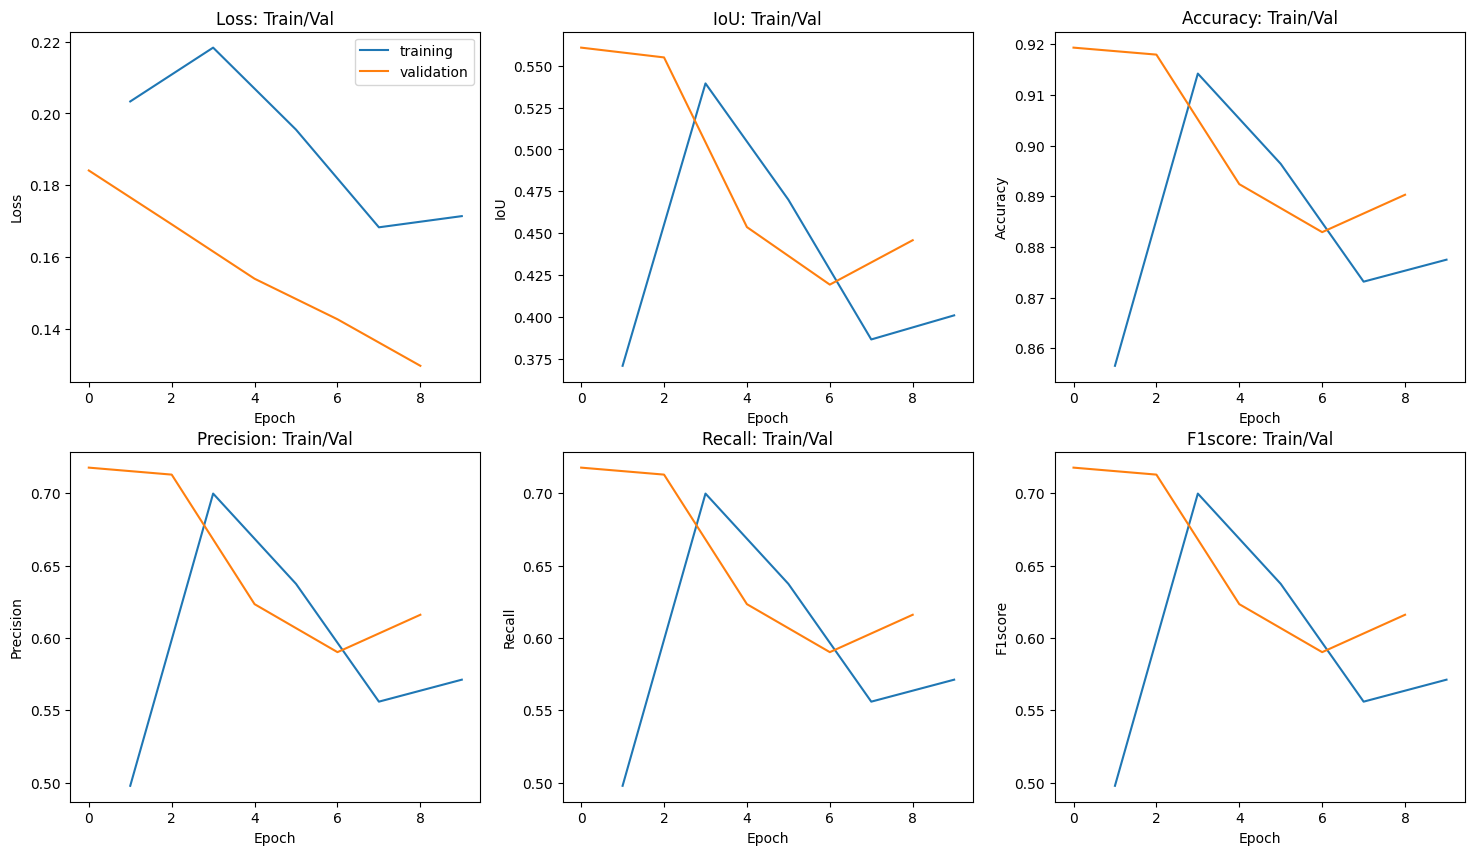

In [21]:
metrics = pd.read_csv("./lightning_logs/landcover-classification-log/version_0/metrics.csv")
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(18, 10))

axes = [ax1, ax2, ax3, ax4, ax5, ax6]
names = ['Loss', 'IoU', 'Accuracy', 'Precision', 'Recall', 'F1score']

for axis, name in zip(axes, names):
    axis.plot(metrics[f'train/{name}'].dropna())
    axis.plot(metrics[f'val/{name}'].dropna())
    axis.set_title(f'{name}: Train/Val')
    axis.set_ylabel(name)
    axis.set_xlabel('Epoch')
    ax1.legend(['training', 'validation'], loc="upper right")